# EDA – NIH Chest X-Rays

This Exploratory Data Analysis (EDA) explores the NIH dataset used to train the deep learning model that detects Pneumonia. It is worth mentioning that the dataset was not specifically acquired for pneumonia and, therefore, it represents the prevalence of Pneumonia in a general population that took a chest X-Ray.

Main findings:
- Demographics:
    - All:
        - Ages (years old): 1 to 95, median=49, mode=58
        - Sex: 56% males, 44% females
    - With Pneumonia:
        - Ages (years old): 2 to 90, median=46, mode=33
        - Sex: 59% males, 41% females
        
- X-Rays views:
    - 60% PA
    - 40% AP
    - The PA tends to have better image contrast and quality than AP the view
    
- Disease numbers per image:
    - Images without any disease: 60,353 out of 112,104 (54%)
    - 28% of the images contain one disease
    - 13% of the images contain two diseases
    - 5% of the images contain three or more diseases
    - Images with Pneumonia: 1430 out of 112,104 (1.28 %), where:
        - 322 only Pneumonia
        - 543 with another disease
        - 386 with two other diseases
        - Pneumonia is often found with Infiltration, Edema, Effusion, and Atelectasis

- Disease numbers per patient:
    - 53% of the patients do not contain any finding
    - 25% of the patients contain one disease
    - 12% of the patients contain two diseases
    - 10% of the patients contain three or more diseases
    - 3% of the patients reported Pneumonia

- Pixel-level assessments:
    - Images with no findings tend to have lower image intensities than images with diseases due to the presence of fluid or other abnormalities in the latter
    - Images with Pneumonia and Infiltration present the clearest difference with images with no findings
    - The differences in intensities between images with and without diseases can be better visualised in lung fragments where disease images tend to be blurrier (whiter) in background areas
    - PA views offer the clearest background separation

## Index
1. [Import libraries](#imports)
2. [Data loading](#data_loading)
3. [Data cleaning](#data_cleaning)
4. [Exploratory data analysis](#eda)
    1. [Patient Demographics](#patient_demographics)
    2. [X-Rays views](#xrays_views)
    3. [Distribution of Pneumonia](#pneumonia_distribution)
    4. [Pixel-level assessments](#pixel_assessments)

## 1. Import libraries
<a id='imports'></a>

In [1]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats

from glob import glob
from itertools import chain
from skimage import filters
%matplotlib inline
sns.set_style('white')
plt.rc("axes.spines", top=False, right=False)

## 2. Data loading
<a id='data_loading'></a>

In [2]:
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
print('Shape of all_xray_df:', all_xray_df.shape)
all_xray_df.sample(3)

Shape of all_xray_df: (112120, 12)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
58954,00014593_003.png,No Finding,3,14593,23,F,AP,2500,2048,0.168000,0.168000,NaN
107582,00029059_000.png,Infiltration,0,29059,4,M,PA,1728,1413,0.194311,0.194311,NaN
15811,00004174_001.png,Infiltration,1,4174,39,M,PA,2754,2991,0.143000,0.143000,NaN


In [3]:
## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
print('Shape of sample_df:', sample_df.shape)
sample_df.sample(3)

Shape of sample_df: (5606, 11)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
4998,00026374_009.png,Consolidation,9,26374,087Y,M,AP,3056,2544,0.139000,0.139000
5400,00029174_000.png,No Finding,0,29174,005Y,M,AP,1362,1395,0.194311,0.194311
1992,00010417_001.png,Infiltration,1,10417,047Y,F,PA,2048,2500,0.168000,0.168000


### 2.1. Overview of Data_Entry_2017

In [4]:
print(f'Number of entries: {all_xray_df.shape[0]:,.0f}')
print(f'Number of unique images: {all_xray_df["Image Index"].nunique():,.0f}')
print(f'Number of unique patients: {all_xray_df["Patient ID"].nunique():,.0f}')
print(f'Number of unique labels: {all_xray_df["Finding Labels"].nunique():,.0f}')
print(f'Number of unique genders: {all_xray_df["Patient Gender"].nunique():,.0f}')
print(f'Number of unique view positions: {all_xray_df["View Position"].nunique():,.0f}')

Number of entries: 112,120
Number of unique images: 112,120
Number of unique patients: 30,805
Number of unique labels: 836
Number of unique genders: 2
Number of unique view positions: 2


In [5]:
all_xray_df.describe(include='all')

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
count,112120,112120,112120.000000,112120.000000,112120.000000,112120,112120,112120.000000,112120.000000,112120.000000,112120.000000,0.0
unique,112120,836,NaN,NaN,NaN,2,2,NaN,NaN,NaN,NaN,NaN
top,00001689_004.png,No Finding,NaN,NaN,NaN,M,PA,NaN,NaN,NaN,NaN,NaN
freq,1,60361,NaN,NaN,NaN,63340,67310,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,8.573751,14346.381743,46.901463,NaN,NaN,2646.078844,2486.438842,0.155649,0.155649,NaN
std,NaN,NaN,15.406320,8403.876972,16.839923,NaN,NaN,341.246429,401.268227,0.016174,0.016174,NaN
min,NaN,NaN,0.000000,1.000000,1.000000,NaN,NaN,1143.000000,966.000000,0.115000,0.115000,NaN
25%,NaN,NaN,0.000000,7310.750000,35.000000,NaN,NaN,2500.000000,2048.000000,0.143000,0.143000,NaN
50%,NaN,NaN,3.000000,13993.000000,49.000000,NaN,NaN,2518.000000,2544.000000,0.143000,0.143000,NaN
75%,NaN,NaN,10.000000,20673.000000,59.000000,NaN,NaN,2992.000000,2991.000000,0.168000,0.168000,NaN


In [6]:
outliers_age = all_xray_df[all_xray_df['Patient Age'] > 100]
print('Number of outliers with age > 100 years old:', outliers_age.shape[0])
outliers_age

Number of outliers with age > 100 years old: 16


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
20852,00005567_000.png,Effusion|Pneumonia,0,5567,412,M,AP,3056,2544,0.139,0.139,NaN
46965,00011973_002.png,Edema,2,11973,414,M,AP,3056,2544,0.139,0.139,NaN
48284,00012238_010.png,No Finding,10,12238,148,M,PA,2992,2991,0.143,0.143,NaN
55742,00013950_000.png,No Finding,0,13950,148,M,PA,2964,2939,0.143,0.143,NaN
58650,00014520_026.png,Infiltration|Mass,26,14520,150,M,PA,2992,2991,0.143,0.143,NaN
62929,00015558_000.png,No Finding,0,15558,149,M,PA,2992,2991,0.143,0.143,NaN
74884,00018366_044.png,Pneumothorax,44,18366,152,F,PA,2302,2991,0.143,0.143,NaN
78795,00019346_000.png,Infiltration,0,19346,151,F,PA,2678,2774,0.143,0.143,NaN
84810,00020900_002.png,No Finding,2,20900,411,M,AP,3056,2544,0.139,0.139,NaN
85404,00021047_002.png,Mass|Pleural_Thickening,2,21047,412,M,AP,3056,2544,0.139,0.139,NaN


In [7]:
all_xray_df['Unnamed: 11'].value_counts(dropna=False)

NaN    112120
Name: Unnamed: 11, dtype: int64

In [8]:
# Look for NaNs besides the last column
all_xray_df.iloc[:, :-1].isna().any(axis=1).any()

False

There are no NaN entries besides the `Unnamed: 11` column.

### 2.2. Overview of sample_labels.csv

In [9]:
print(f'Number of entries: {sample_df.shape[0]:,.0f}')
print(f'Number of unique images: {sample_df["Image Index"].nunique():,.0f}')
print(f'Number of unique patients: {sample_df["Patient ID"].nunique():,.0f}')
print(f'Number of unique labels: {sample_df["Finding Labels"].nunique():,.0f}')

Number of entries: 5,606
Number of unique images: 5,606
Number of unique patients: 4,230
Number of unique labels: 244


In [10]:
# Look for NaNs
sample_df.isna().any(axis=1).any()

False

## 3. Data cleaning
<a id='data_cleaning'></a>

In [11]:
all_xray_df = all_xray_df.drop(columns='Unnamed: 11')

In [12]:
# Drop outliers with ages higher than 100 years old to avoid biases
# Reason: There are just 16 entries out of 112,120
all_xray_df = all_xray_df.loc[all_xray_df['Patient Age'] <= 100].copy()

## 4. Exploratory Data Analysis
<a id='eda'></a>

This section explores the following information:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

## 4.1. Patient Demographics
<a id='patient_demographics'></a>

#### 4.1.1. Age

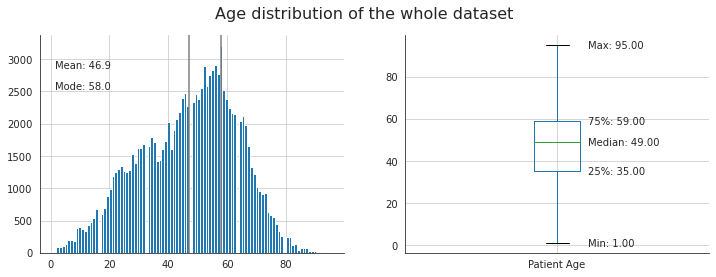

In [13]:
def plot_hist_and_boxplot(df, col, title):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    df[col].hist(bins=100, ax=ax[0])
    df.boxplot(column=col, ax=ax[1])

    # Add annotations
    min_value = df[col].min()
    p_25 = df[col].quantile(0.25)
    mean_value = df[col].mean()
    median_value = df[col].median()
    p_75 = df[col].quantile(0.75)
    max_value = df[col].max()
    mode_value = df[col].mode()[0]

    ax[0].axvline(mean_value, c='gray')
    ax[0].axvline(mode_value, c='gray')
    ax[0].annotate(f'Mean: {mean_value:.1f}', (0.05, 0.85), xycoords='axes fraction')
    ax[0].annotate(f'Mode: {mode_value:.1f}', (0.05, 0.75), xycoords='axes fraction')

    ax[1].text(1.1, median_value, f'Median: {median_value:.2f}', va='center', ha='left')
    ax[1].text(1.1, p_25, f'25%: {p_25:.2f}', va='center', ha='left')
    ax[1].text(1.1, p_75, f'75%: {p_75:.2f}', va='center', ha='left')
    ax[1].text(1.1, min_value, f'Min: {min_value:.2f}', va='center', ha='left')
    ax[1].text(1.1, max_value, f'Max: {max_value:.2f}', va='center', ha='left')

    fig.suptitle(title, fontsize=16)
    

plot_hist_and_boxplot(all_xray_df, 'Patient Age', 'Age distribution of the whole dataset')

#### 4.1.2. Gender

In [14]:
all_xray_df['Patient Gender'].value_counts(normalize=True)

M    0.564904
F    0.435096
Name: Patient Gender, dtype: float64

### 4.2. The X-Rays views taken
<a id='xrays_views'></a>

In [15]:
all_xray_df['View Position'].value_counts(normalize=True)

PA    0.600326
AP    0.399674
Name: View Position, dtype: float64

### 4.3. Distribution of Pneumonia
<a id='pneumonia_distribution'></a>

#### 4.3.1. Number of Pneumonia cases

In [16]:
all_xray_df['has_pneumonia'] = all_xray_df['Finding Labels'].map(lambda x: 'Pneumonia' in x)
print(f'Number of cases with Pneumonia: ' +
        f'{len(all_xray_df.query("has_pneumonia"))} / {len(all_xray_df)}' +
        f' ({all_xray_df.has_pneumonia.mean()*100:.2f} %)')

Number of cases with Pneumonia: 1430 / 112104 (1.28 %)


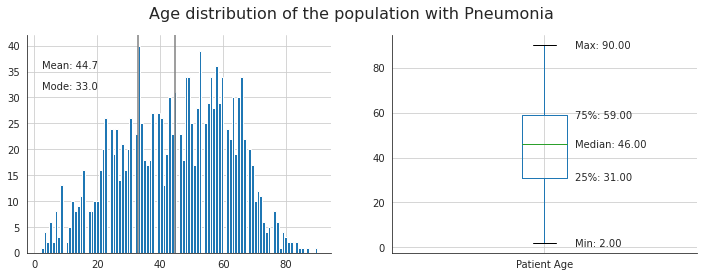

In [17]:
plot_hist_and_boxplot(
    all_xray_df.query("has_pneumonia"), 
    'Patient Age', 
    'Age distribution of the population with Pneumonia')

In [18]:
all_xray_df.query("has_pneumonia")['Patient Gender'].value_counts(normalize=True)

M    0.585315
F    0.414685
Name: Patient Gender, dtype: float64

#### 4.3.2. Pneumonia prevalence per patient

In [24]:
all_xray_df.groupby(by='Patient ID')['has_pneumonia'].max().mean()

0.03272514771768067

**3% of the patients have Pneumonia**

#### 4.3.3. Co-occurrence with other diseases

Extract from the column "Finding Labels" all separate diseases:

In [26]:
entry_findings = all_xray_df['Finding Labels'].map(lambda x: x.split('|'))
all_diseases = set(chain.from_iterable(entry_findings.tolist()))
print('Number of findings (including "No finding"):', len(all_diseases))
all_diseases

Number of findings (including "No finding"): 15


{'Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'No Finding',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax'}

Next, we build a separate DataFrame to find the co-occurrence matrix and analyse the diseases that are found with Pneumonia.

In [59]:
# Create dataframe with instances of individual findings
diseases = pd.DataFrame(index=all_xray_df.index)
for disease in all_diseases:
    diseases[disease] = all_xray_df['Finding Labels'].map(lambda x: disease in x)

diseases = diseases.astype(np.int64)
diseases.head()

,Consolidation,No Finding,Cardiomegaly,Edema,Infiltration,Effusion,Fibrosis,Emphysema,Mass,Atelectasis,Pneumothorax,Hernia,Pleural_Thickening,Pneumonia,Nodule
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
2,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [60]:
assert (
    'Emphysema' in all_xray_df.iloc[1]['Finding Labels'] and
    'Cardiomegaly' in all_xray_df.iloc[1]['Finding Labels']
)

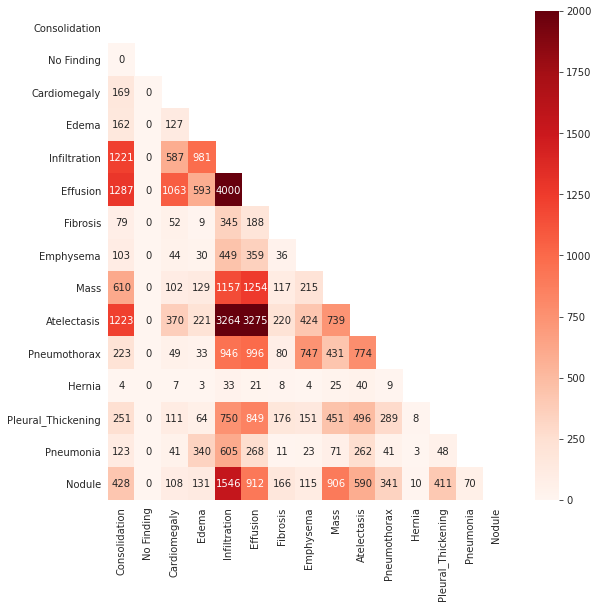

In [61]:
# Generate the co-occurrence matrix
coocc = diseases.T.dot(diseases)
plt.figure(figsize=(9,9))
sns.heatmap(coocc, cmap='Reds', annot=True, mask=np.triu(np.ones_like(coocc)), vmin=0, vmax=2000, fmt='.0f')

In [62]:
# Validation checks
assert diseases.query('Atelectasis == 1 and Infiltration == 1').shape[0] == 3264
assert diseases.query('Effusion == 1 and Pleural_Thickening == 1').shape[0] == 849
assert (diseases.query('`No Finding` == 1').sum(axis=1) == 1).all()  # `No Finding` appears alone
assert diseases.query('Pneumonia == 1').shape[0] == 1430

From the heatmap above, we can observe that Pneumonia is often found with Infiltration, Edema, Effusion, and Atelectasis. The bar plot below illustrates this fact clearly:

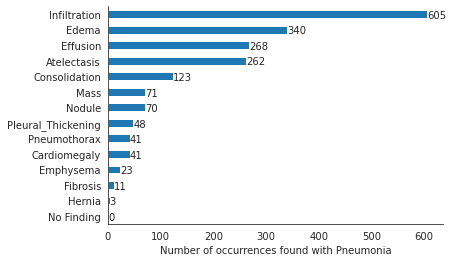

In [63]:
ax = coocc.loc['Pneumonia', coocc.columns != 'Pneumonia'].sort_values().plot(kind='barh')
ax.set_xlabel('Number of occurrences found with Pneumonia')
for p in ax.patches:
    ax.annotate(p.get_width(), (p.get_width(), p.get_y()))

In [64]:
ratio = (
    diseases.query('Pneumonia == 1 and Infiltration == 1').shape[0] / 
    diseases.query('Pneumonia == 1').shape[0]
)
print(f'Proportion of Pneumonia cases with Infiltration: {ratio*100:,.1f}%')

Proportion of Pneumonia cases with Infiltration: 42.3%


Finally, let's evaluate the number of diseases found with Pneumonia in the dataset:

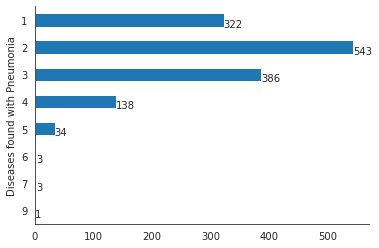

In [65]:
ax = (
    diseases.query('Pneumonia == 1').sum(axis=1)
    .value_counts()
    .sort_index(ascending=False)
    .plot(kind='barh')
)
ax.set_ylabel('Diseases found with Pneumonia')
for p in ax.patches:
    ax.annotate(p.get_width(), (p.get_width(), p.get_y()))

So, about one third of Pneumonia cases (N=543) appear with another disease. Then, a quarter of Pneumonia cases appear either alone (N=322) or with two other diseases (N=386).

In [66]:
# Let's find out which are the most common tuples reported with Pneumonia
all_xray_df.query('has_pneumonia').loc[:, 'Finding Labels'].value_counts().head(5)

Pneumonia                       322
Infiltration|Pneumonia          199
Edema|Infiltration|Pneumonia    137
Atelectasis|Pneumonia           108
Edema|Pneumonia                  83
Name: Finding Labels, dtype: int64

In [67]:
# Validate: how many cases of Pneumonia-only findings we have
all_xray_df.query('`Finding Labels` == "Pneumonia"').shape[0]

322

#### 4.3.4. Number of diseases in the dataset

In [68]:
print(f'Number of images without any disease: '+
      f'{diseases.query("`No Finding` == 1").shape[0]:,.0f} / {diseases.shape[0]:,.0f}'+
      f' ({diseases.query("`No Finding` == 1").shape[0] / diseases.shape[0] * 100:,.0f}%)') 

Number of images without any disease: 60,353 / 112,104 (54%)


In [70]:
diseases['n_diseases'] = diseases.loc[:, diseases.columns != 'No Finding'].sum(axis=1)

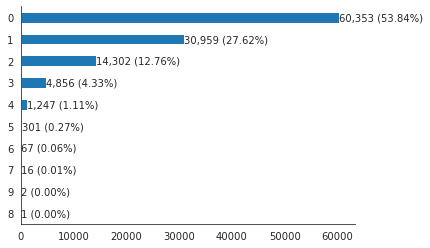

In [79]:
ax = diseases.n_diseases.value_counts().sort_values(ascending=True).plot(kind='barh')
N_all = diseases.shape[0]
for p in ax.patches:
    ax.annotate(f'{p.get_width():,.0f} ({p.get_width()/N_all*100:.2f}%)', 
                (p.get_width(), p.get_y()), ha='left', va='bottom')

- 54% of the images do not contain any finding
- 28% of the images contain one disease
- 13% of the images contain two diseases
- 5% of the images contain three or more diseases

#### 4.3.5. Number of diseases per patient

In [80]:
assert np.allclose(diseases.index, all_xray_df.index)

diseases['Patient ID'] = all_xray_df['Patient ID']

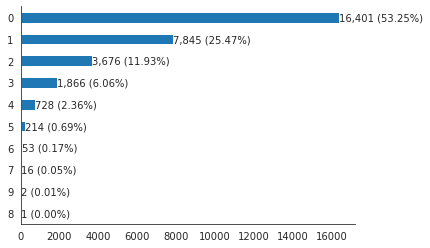

In [83]:
ax = (
    diseases.groupby('Patient ID').n_diseases
        .max()
        .value_counts()
        .sort_values()
        .plot(kind='barh')
)
N_all = diseases['Patient ID'].nunique()
for p in ax.patches:
    ax.annotate(f'{p.get_width():,.0f} ({p.get_width()/N_all*100:.2f}%)', 
                (p.get_width(), p.get_y()), ha='left', va='bottom')

- 53% of the patients do not contain any finding
- 25% of the patients contain one disease
- 12% of the patients contain two diseases
- 10% of the patients contain three or more diseases

### 4.4. Pixel-level assessments
<a id='pixel_assessments'></a>

This section explores images and pixel distributions of images with:
- No findings
- Pneumonia
- Infiltration
- Edema
- Effusion
- Atelectasis

For each of these diseases, the analysis also explores differences in View Position (AP vs PA).

In [31]:
sample_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168


In [96]:
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}


def mean_and_std(pixel_array): 
    return pixel_array.mean(), pixel_array.std()


def standardise_image(image):
    mean, std = mean_and_std(image)
    new_img = image.copy()
    return (new_img - mean) / std 


def norm_image(image):
    new_img = image.copy()
    return new_img / 255


def load_img(img_path):
    img = plt.imread(img_path, format='PNG')
    return img


def plot_img(img, ax):
    ax.imshow(img, cmap='gray')

    
def plot_intensities(img, ax, rng=(0, 1), bins=50, annot=True):
    ax.hist(img, range=rng, bins=bins)
    if annot:
        ax.axvline(img.mean(), c='gray')
        ax.annotate(f'mean={img.mean():.2f}', (0.05, 0.7), xycoords='axes fraction', ha='left')
        ax.annotate(f'std={img.std():.2f}', (0.05, 0.5), xycoords='axes fraction', ha='left')
        ax.annotate(f'75%={np.percentile(img, 75):.2f}', (0.05, 0.3), xycoords='axes fraction', ha='left')
    

def plot_samples(df, N_SAMPLES=6, subtitle=''):
    n_samples = min(N_SAMPLES, len(df))
    images = df.loc[:, 'Image Index'].sample(n_samples)

    means, stds, p_75 = [], [], []
    
    fig, ax = plt.subplots(n_samples, 3, figsize=(8, 14))
    for i in range(n_samples):
        img = load_img(all_image_paths[images.iloc[i]])
        plot_img(img, ax[i, 0])

        # Apply Otsu mask
        val = filters.threshold_otsu(img)
        plot_img(img > val, ax[i, 1])
        
        # Plot intensities
        img_norm = norm_image(img[img > val])
        plot_intensities(img_norm, ax[i, 2])
        
        means.append(img_norm.mean())
        stds.append(img_norm.std())
        p_75.append(np.percentile(img_norm, 75))
        
        ax[i, 0].axis('off')
        ax[i, 1].axis('off')
        ax[i, 2].set_yticks([])
        
    ax[0, 0].set_title('Original')
    ax[0, 1].set_title('OTSU')
    ax[0, 2].set_title('Norm. intensities')
    fig.suptitle(subtitle)
    print('Sample stats')
    print('Avg. mean intensity:', np.mean(means))
    print('Avg. std intensity:', np.mean(stds))
    print('Avg. p_75 intensity:', np.mean(p_75))
    plt.tight_layout()
    plt.subplots_adjust(top=0.95, wspace=0,)
    

def plot_pixel_data(df, n_samples=6, subtitle=''):
    print(subtitle)
    print('Number of images available:', df.shape[0])
    plot_samples(df=df, N_SAMPLES=n_samples, subtitle=subtitle)
    

def plot_fragment(img, x, width, y, height):
    _, ax = plt.subplots(1, 3, figsize=(6, 2))
    fragment = img[x:x+width, y:y+height]
    
    mask = np.array(img)    
    mask[y:y+height, x:x+width] = 0

    plot_img(mask, ax[0])
    plot_img(fragment, ax[1])
    plot_intensities(norm_image(fragment.ravel()), ax[2], annot=False)
    plt.tight_layout()

#### 4.4.1. Images with no findings

No findings - AP
Number of images available: 1057
Sample stats
Avg. mean intensity: 0.653173909374891
Avg. std intensity: 0.10572736471999722
Avg. p_75 intensity: 0.7362745098039215


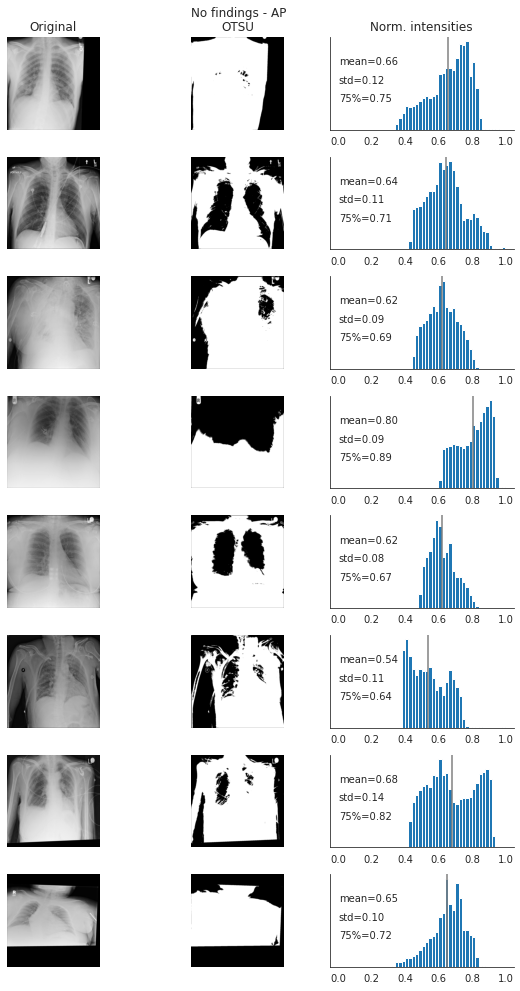

In [97]:
images_no_findings = sample_df.query('`Finding Labels` == "No Finding"')
images_ap = images_no_findings.query('`View Position` == "AP"')
images_pa = images_no_findings.query('`View Position` == "PA"')

plot_pixel_data(images_ap, n_samples=8, subtitle='No findings - AP')

No findings - PA
Number of images available: 1987
Sample stats
Avg. mean intensity: 0.6940855740187886
Avg. std intensity: 0.0976451619904513
Avg. p_75 intensity: 0.7754901960784314


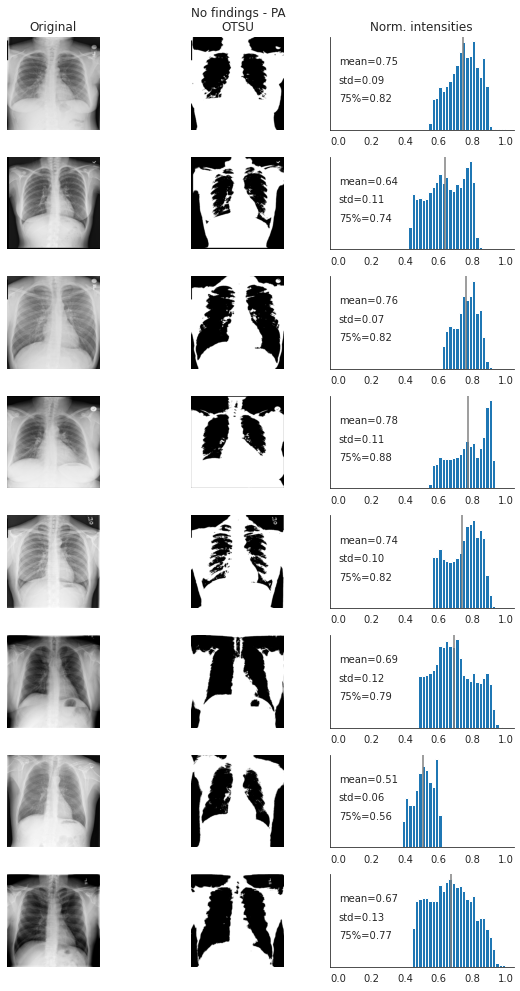

In [98]:
plot_pixel_data(images_pa, n_samples=8, subtitle='No findings - PA')

The quality of the PA view position seems much higher than the AP view. Due to the enhanced contrast, the OTSU filter performs a clearer separation from the background. As a result of this separation, the mean of the sample intensities is higher in the PA view.

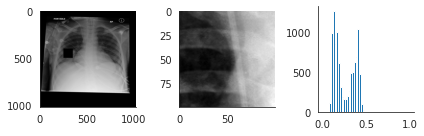

In [88]:
# Plot a fragment of the lung to use as a comparison
images_no_findings = images_no_findings.sample(1)
image_path = images_no_findings['Image Index'].item()
frag_no_finding = load_img(all_image_paths[image_path])

plot_fragment(frag_no_finding, x=250, width=100, y=400, height=100)

#### 4.4.2. Images with only Pneumonia
Pneumonia is an infection that affects one or both lungs. It causes the air sacs, or alveoli, of the lungs to fill up with fluid or pus. So, we would expect whiter areas on the background ([source](https://www.nhlbi.nih.gov/health/pneumonia#:~:text=Pneumonia%20is%20an%20infection%20that,or%20fungi%20may%20cause%20pneumonia.))

Pneumonia - AP
Number of images available: 6
Sample stats
Avg. mean intensity: 0.6102123198628683
Avg. std intensity: 0.1183207309697702
Avg. p_75 intensity: 0.7071895424836602
Pneumonia - PA
Number of images available: 8
Sample stats
Avg. mean intensity: 0.6851479402187419
Avg. std intensity: 0.13443693434367032
Avg. p_75 intensity: 0.7955882352941177


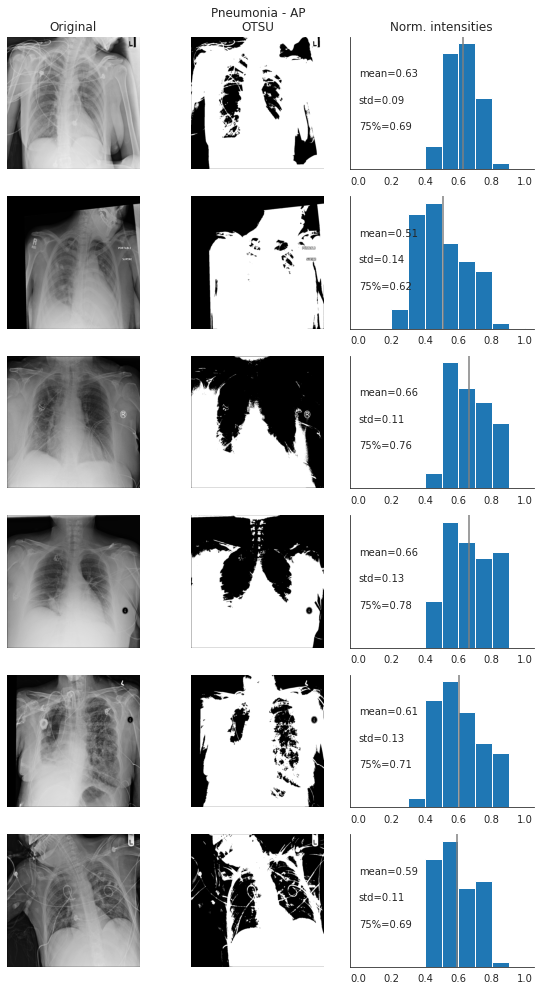

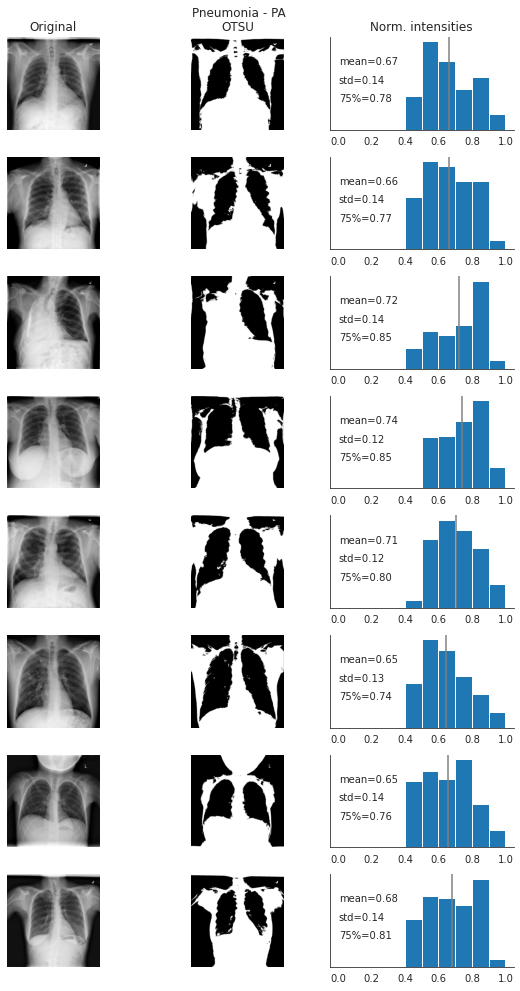

In [35]:
samples_with_pneumonia = sample_df.query('`Finding Labels` == "Pneumonia"')
images_ap = samples_with_pneumonia.query('`View Position` == "AP"')
images_pa = samples_with_pneumonia.query('`View Position` == "PA"')

plot_pixel_data(images_ap, n_samples=8, subtitle='Pneumonia - AP')
plot_pixel_data(images_pa, n_samples=8, subtitle='Pneumonia - PA')

- The AP view of images with only Pneumonia look similar to the ones with no findings. Image intensities with Pneumonia have a slightly superior percentile 75 (likely due to more blurry images) and similar mean.
- The PA view present more contrast than the AP view.
- The PA view of Pneumonia has higher mean intensity and percentile 75 than images with no findings.

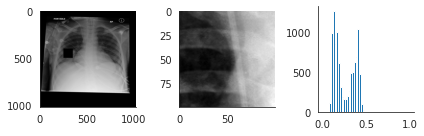

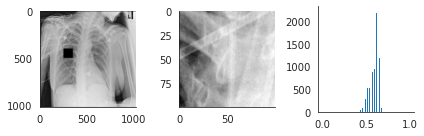

In [89]:
# Fragment comparison with no finding
image_path = samples_with_pneumonia.sample(1)['Image Index'].item()
frag_pneumonia = load_img(all_image_paths[image_path])

plot_fragment(frag_no_finding, x=250, width=100, y=400, height=100)
plot_fragment(frag_pneumonia, x=250, width=100, y=400, height=100)

The intensities of the lung with Pneumonia are shifted towards the right, and the difference is evident from the Figure.

#### 4.4.3. Images with Pneumonia and Infiltration
Persistent pulmonary infiltrate results when a substance denser than air (e.g., pus, oedema, blood, surfactant, protein, or cells) lingers within the lung parenchyma ([source](https://bestpractice.bmj.com/topics/en-gb/1094#:~:text=08%20Feb%202023-,Summary,categories%20of%20persistent%20pulmonary%20infiltrate.%5B)).

Pneumonia and Infiltration - AP
Number of images available: 17
Sample stats
Avg. mean intensity: 0.5913311352893145
Avg. std intensity: 0.12289032556090204
Avg. p_75 intensity: 0.6950980392156862
Pneumonia and Infiltration - PA
Number of images available: 6
Sample stats
Avg. mean intensity: 0.7042742273403189
Avg. std intensity: 0.13272993124230123
Avg. p_75 intensity: 0.823529411764706


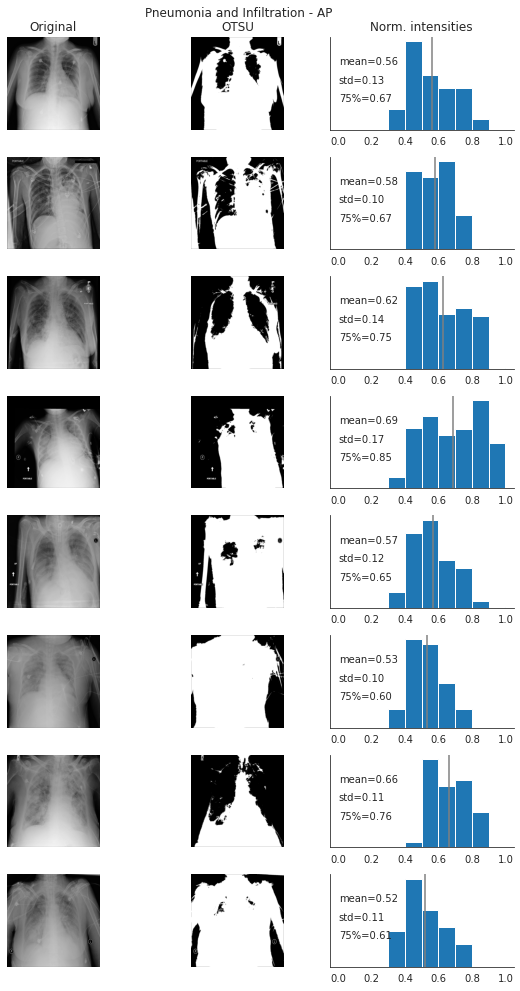

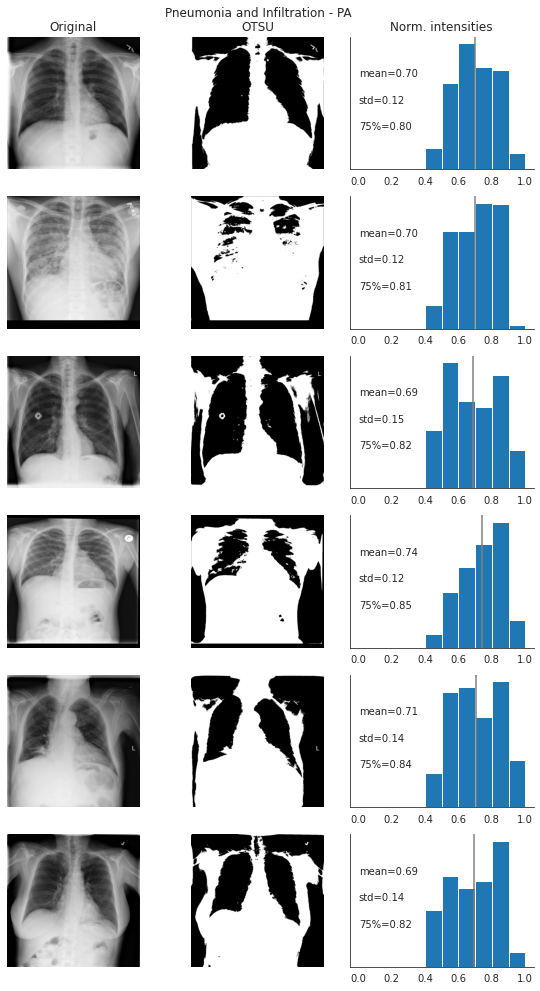

In [42]:
sample_df['pneumonia_and_infiltration'] = sample_df['Finding Labels'].map(
    lambda x: 'Infiltration' in x and 'Pneumonia' in x
)
samples_with_pneumonia_and_inf = sample_df.query('pneumonia_and_infiltration')
images_ap = samples_with_pneumonia_and_inf.query('`View Position` == "AP"')
images_pa = samples_with_pneumonia_and_inf.query('`View Position` == "PA"')

plot_pixel_data(images_ap, n_samples=8, subtitle='Pneumonia and Infiltration - AP')
plot_pixel_data(images_pa, n_samples=8, subtitle='Pneumonia and Infiltration - PA')

We can observe that when the patients have Pneumonia and Infiltration, the pixel intensities are shifted towards the right (i.e., more intense areas). This fact can be observed in the average sample intensity and the average of the 75% percentile in both AP and PA images compared to images with no findings.

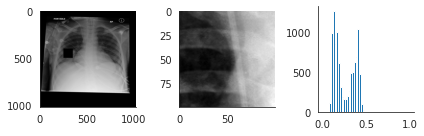

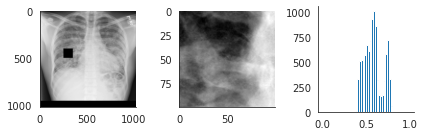

In [90]:
# Fragment comparison with no finding
image_path = samples_with_pneumonia_and_inf.sample(1)['Image Index'].item()
frag_pneumonia_inf = load_img(all_image_paths[image_path])

plot_fragment(frag_no_finding, x=250, width=100, y=400, height=100)
plot_fragment(frag_pneumonia_inf, x=250, width=100, y=400, height=100)

Again, the fragments show the clear difference between a lung with no findings and a lung with pneumonia and infiltration. The latter has a blurrier image than the former.

#### 4.4.4. Images with  Edema
Pulmonary edema is an abnormal buildup of fluid in the lungs. This buildup of fluid leads to shortness of breath ([source](https://www.pennmedicine.org/for-patients-and-visitors/patient-information/conditions-treated-a-to-z/pulmonary-edema#:~:text=Pulmonary%20edema%20is%20an%20abnormal,leads%20to%20shortness%20of%20breath.)).

Edema - AP
Number of images available: 106
Sample stats
Avg. mean intensity: 0.583081546002642
Avg. std intensity: 0.11213740413003183
Avg. p_75 intensity: 0.6705882352941176
Edema - PA
Number of images available: 12
Sample stats
Avg. mean intensity: 0.6849225623642439
Avg. std intensity: 0.11105414994867024
Avg. p_75 intensity: 0.7833333333333333


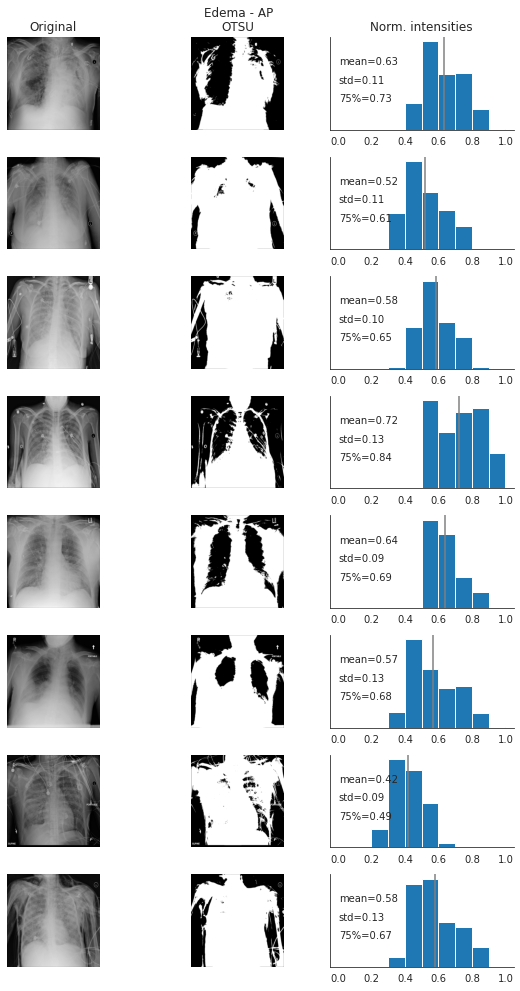

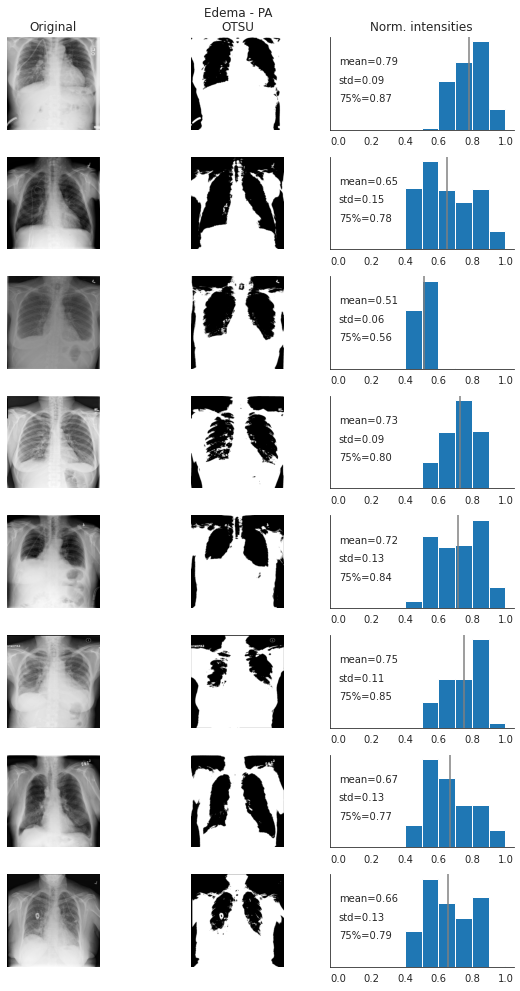

In [43]:
sample_df['edema'] = sample_df['Finding Labels'].map(
    lambda x: 'Edema' in x
)
samples_with_edema = sample_df.query('edema')
images_ap = samples_with_edema.query('`View Position` == "AP"')
images_pa = samples_with_edema.query('`View Position` == "PA"')

plot_pixel_data(images_ap, n_samples=8, subtitle='Edema - AP')
plot_pixel_data(images_pa, n_samples=8, subtitle='Edema - PA')

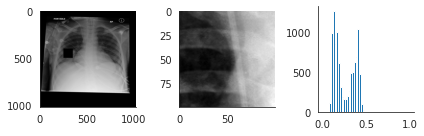

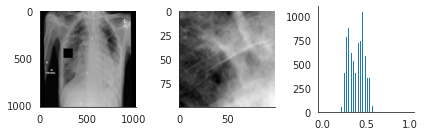

In [92]:
# Fragment comparison with no finding
image_path = samples_with_edema.sample(1)['Image Index'].item()
frag_edema = load_img(all_image_paths[image_path])

plot_fragment(frag_no_finding, x=250, width=100, y=400, height=100)
plot_fragment(frag_edema, x=250, width=100, y=400, height=100)

With Edema, the difference is not as clear as in the previous cases. Still, the mode of the fragment with the disease is higher than with no disease.

#### 4.4.5. Images with Effusion
Pleural effusion, sometimes referred to as “water on the lungs,” is the build-up of excess fluid between the layers of the pleura outside the lungs. The pleura are thin membranes that line the lungs and the inside of the chest cavity and act to lubricate and facilitate breathing ([source](https://my.clevelandclinic.org/health/diseases/17373-pleural-effusion-causes-signs--treatment)).

Effusion - AP
Number of images available: 308
Sample stats
Avg. mean intensity: 0.6381919752702733
Avg. std intensity: 0.1094101114693411
Avg. p_75 intensity: 0.7274509803921568
Effusion - PA
Number of images available: 336
Sample stats
Avg. mean intensity: 0.6850307300955556
Avg. std intensity: 0.12264724267749907
Avg. p_75 intensity: 0.7946078431372549


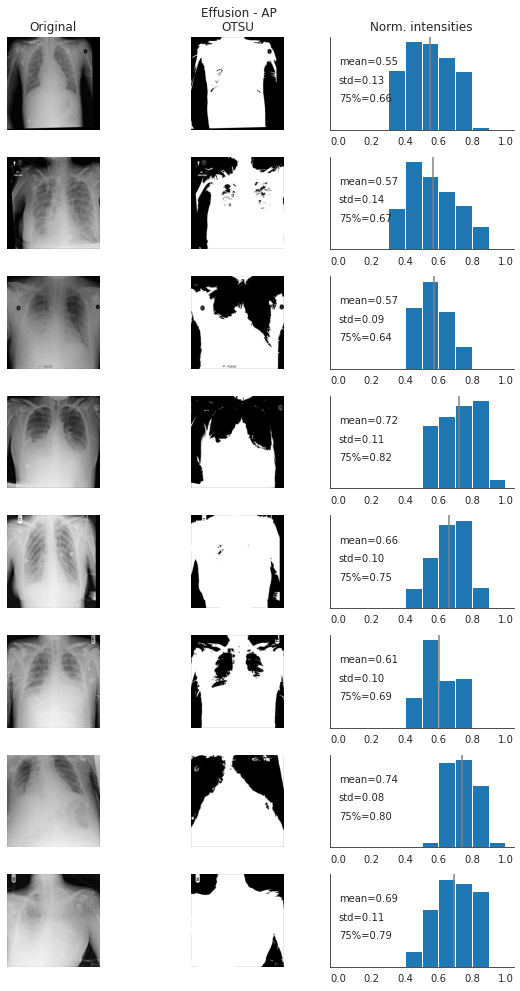

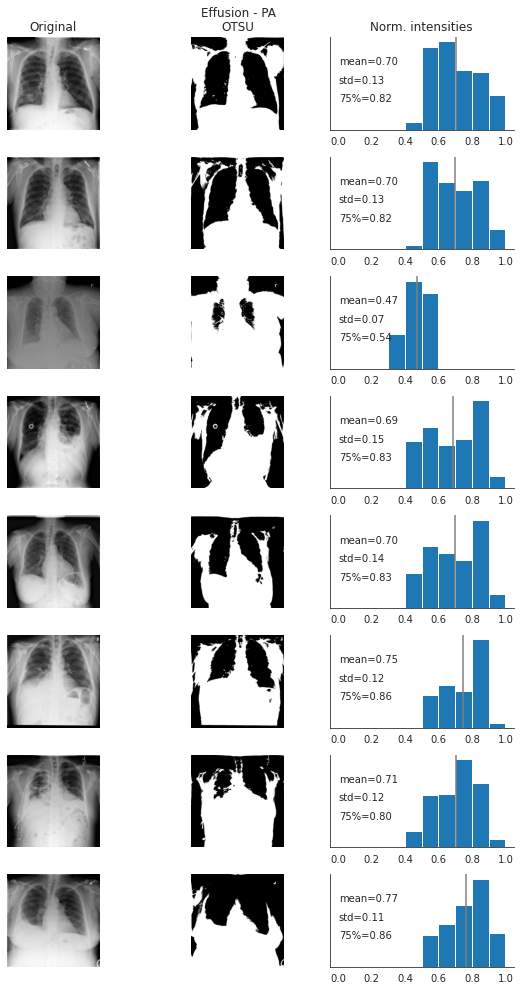

In [46]:
sample_df['effusion'] = sample_df['Finding Labels'].map(
    lambda x: 'Effusion' in x
)
samples_with_effusion = sample_df.query('effusion')
images_ap = samples_with_effusion.query('`View Position` == "AP"')
images_pa = samples_with_effusion.query('`View Position` == "PA"')

plot_pixel_data(images_ap, n_samples=8, subtitle='Effusion - AP')
plot_pixel_data(images_pa, n_samples=8, subtitle='Effusion - PA')

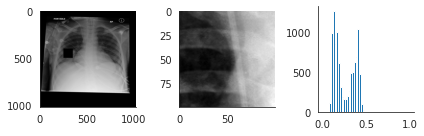

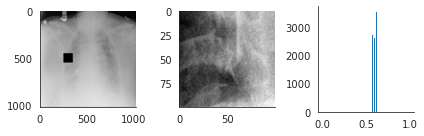

In [94]:
# Fragment comparison with no finding
image_path = samples_with_effusion.sample(1)['Image Index'].item()
frag_effusion = load_img(all_image_paths[image_path])

plot_fragment(frag_no_finding, x=250, width=100, y=400, height=100)
plot_fragment(frag_effusion, x=250, width=100, y=450, height=100)

#### 4.4.6. Images with Atelectasis
Atelectasis, the collapse of part or all of a lung, is caused by a blockage of the air passages (bronchus or bronchioles) or by pressure on the lung ([source](https://www.hopkinsmedicine.org/health/conditions-and-diseases/atelectasis#:~:text=What%20is%20atelectasis%3F,breathing%20and%20underlying%20lung%20disease.)).

Atelectasis - AP
Number of images available: 257
Sample stats
Avg. mean intensity: 0.6429202233865596
Avg. std intensity: 0.09693237945610803
Avg. p_75 intensity: 0.7254901960784315
Atelectasis - PA
Number of images available: 251
Sample stats
Avg. mean intensity: 0.6367315304858631
Avg. std intensity: 0.10920415394085226
Avg. p_75 intensity: 0.7259803921568627


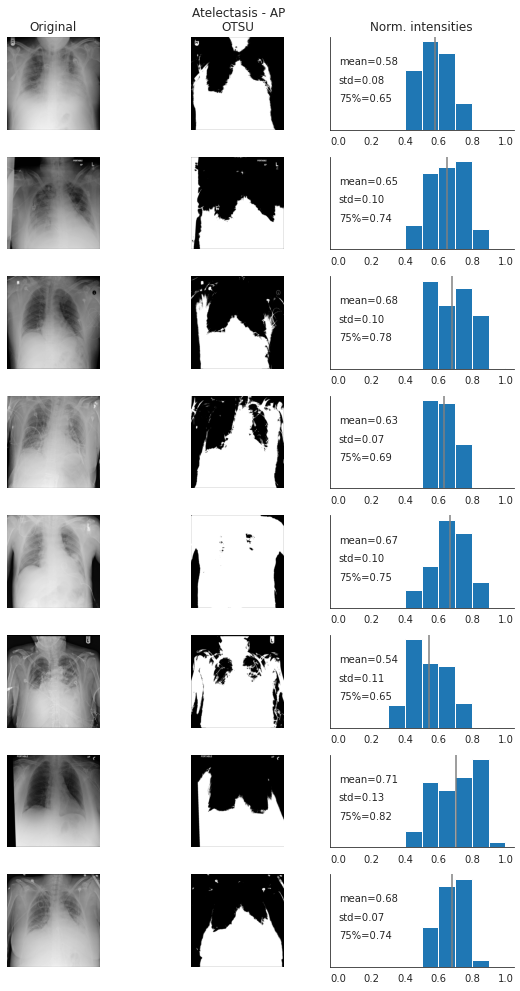

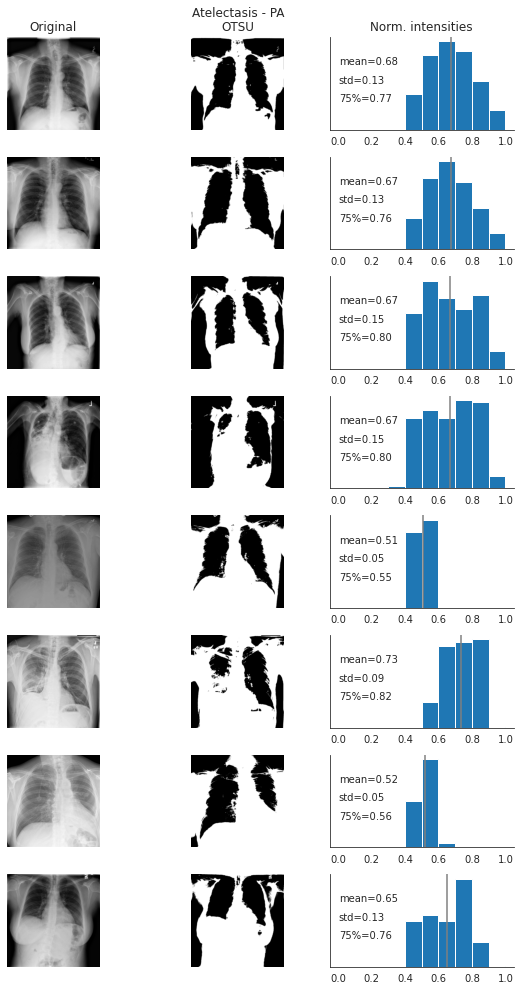

In [45]:
sample_df['atelectasis'] = sample_df['Finding Labels'].map(
    lambda x: 'Atelectasis' in x
)
samples_with_atelectasis = sample_df.query('atelectasis')
images_ap = samples_with_atelectasis.query('`View Position` == "AP"')
images_pa = samples_with_atelectasis.query('`View Position` == "PA"')

plot_pixel_data(images_ap, n_samples=8, subtitle='Atelectasis - AP')
plot_pixel_data(images_pa, n_samples=8, subtitle='Atelectasis - PA')

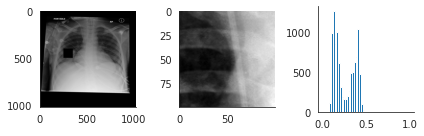

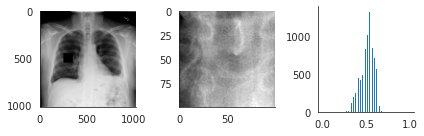

In [95]:
image_path = samples_with_atelectasis.sample(1)['Image Index'].item()
frag_atelectasis = load_img(all_image_paths[image_path])

plot_fragment(frag_no_finding, x=250, width=100, y=400, height=100)
plot_fragment(frag_atelectasis, x=250, width=100, y=450, height=100)

Similarly to the case with Pneumonia and Infiltration, the fragments difference can also be observed in the intensity plot where the image with the disease has higher pixel intensities.